# Phishing Email Detection using DistilBERT

## Model Configuration
- **BERT Variant**: distilbert-base-uncased (6 layers)
- **Sequence Length**: 256 tokens
- **LSTM**: 1-layer BiLSTM, 128 hidden units
- **Layer Training**: Freeze first 3 layers, train last 3 + LSTM
- **Batch Size**: 8 (with gradient accumulation 4 = effective 32)
- **Dropout**: 0.3
- **Learning Rates**: BERT 2e-5, LSTM 1e-3
- **Epochs**: 5 (with early stopping, patience=2)
- **Mixed Precision**: FP16 enabled
- **Input**: Text only (subject + body)

## 1. Install and Import Required Libraries

In [ ]:
# Install required packages (run once)
# !pip install transformers torch pandas numpy scikit-learn matplotlib seaborn tqdm

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from transformers import DistilBertTokenizer, DistilBertModel

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1650
CUDA memory: 4.29 GB


## 2. Configuration Parameters

In [7]:
class Config:
    """All hyperparameters and paths in one place"""

    # Paths
    TRAIN_PATH = '../../../data/processed/email-detection/train.csv'
    VAL_PATH = '../../../data/processed/email-detection/val.csv'
    TEST_PATH = '../../../data/processed/email-detection/test.csv'

    # Output directories
    CHECKPOINT_DIR = '../../../models/email-sms-detection/'
    RESULTS_DIR = '../../../results/email-sms-detection'

    # Model parameters
    BERT_MODEL = 'distilbert-base-uncased'
    MAX_LENGTH = 128
    LSTM_HIDDEN_SIZE = 128
    LSTM_LAYERS = 1
    DROPOUT = 0.3

    # Layer freezing (DistilBERT has 6 layers: 0-5)
    FREEZE_LAYERS = [0, 1, 2]  # Freeze first 3 layers
    TRAIN_LAYERS = [3, 4, 5]   # Train last 3 layers

    # Training parameters
    BATCH_SIZE = 12
    GRADIENT_ACCUMULATION_STEPS = 3
    EFFECTIVE_BATCH_SIZE = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS  # 32

    EPOCHS = 5
    BERT_LR = 2e-5
    LSTM_LR = 1e-3
    WEIGHT_DECAY = 0.01

    # Early stopping
    EARLY_STOPPING_PATIENCE = 2

    # Mixed precision
    USE_AMP = True  # Automatic Mixed Precision (FP16)

    # Other
    NUM_WORKERS = 0
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create output directories
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

print("Configuration:")
print(f"  Device: {Config.DEVICE}")
print(f"  Effective Batch Size: {Config.EFFECTIVE_BATCH_SIZE}")
print(f"  BERT Model: {Config.BERT_MODEL}")
print(f"  Max Length: {Config.MAX_LENGTH} tokens")
print(f"  LSTM Hidden: {Config.LSTM_HIDDEN_SIZE}")
print(f"  Freeze Layers: {Config.FREEZE_LAYERS}")
print(f"  Train Layers: {Config.TRAIN_LAYERS}")
print(f"  Mixed Precision: {Config.USE_AMP}")

Configuration:
  Device: cuda
  Effective Batch Size: 36
  BERT Model: distilbert-base-uncased
  Max Length: 128 tokens
  LSTM Hidden: 128
  Freeze Layers: [0, 1, 2]
  Train Layers: [3, 4, 5]
  Mixed Precision: True


## 3. Custom Dataset Class

In [4]:
class PhishingEmailDataset(Dataset):
    """Custom Dataset for loading phishing emails"""

    def __init__(self, csv_path, tokenizer, max_length=256):
        """
        Args:
            csv_path: Path to CSV file (train/val/test)
            tokenizer: DistilBERT tokenizer
            max_length: Maximum sequence length
        """
        print(f"Loading dataset from {csv_path}...")
        self.df = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Extract text and labels
        self.texts = self.df['text'].astype(str).tolist()
        self.labels = self.df['label'].values

        print(f"  Loaded {len(self.texts)} samples")
        print(f"  Label distribution: {np.bincount(self.labels)}")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## 4. Model Architecture: DistilBERT + BiLSTM

In [8]:
class DistilBERTBiLSTM(nn.Module):
    """DistilBERT + BiLSTM for phishing detection"""

    def __init__(self, bert_model_name, lstm_hidden_size, lstm_layers, dropout, freeze_layers):
        super(DistilBERTBiLSTM, self).__init__()

        # Load pre-trained DistilBERT
        self.bert = DistilBertModel.from_pretrained(bert_model_name)

        # Freeze specified BERT layers
        self._freeze_bert_layers(freeze_layers)

        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,  # 768 for DistilBERT
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Classification head
        # BiLSTM outputs: 2 * lstm_hidden_size (forward + backward)
        self.classifier = nn.Linear(lstm_hidden_size * 2, 1)

    def _freeze_bert_layers(self, freeze_layers):
        """Freeze specified transformer layers in DistilBERT"""
        # Freeze embeddings
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        # Freeze specified transformer layers
        for layer_idx in freeze_layers:
            for param in self.bert.transformer.layer[layer_idx].parameters():
                param.requires_grad = False

        print(f"Frozen BERT layers: embeddings + transformer layers {freeze_layers}")

    def forward(self, input_ids, attention_mask):
        """
        Forward pass

        Args:
            input_ids: [batch_size, seq_len]
            attention_mask: [batch_size, seq_len]

        Returns:
            logits: [batch_size, 1]
        """
        # BERT output: [batch_size, seq_len, hidden_size]
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get last hidden state: [batch_size, seq_len, 768]
        sequence_output = bert_output.last_hidden_state

        # BiLSTM: [batch_size, seq_len, 2*lstm_hidden_size]
        lstm_output, (hidden, cell) = self.lstm(sequence_output)

        # Use the last output of BiLSTM
        # hidden: [2*num_layers, batch_size, lstm_hidden_size]
        # Concatenate forward and backward hidden states from last layer
        hidden_forward = hidden[-2, :, :]  # [batch_size, lstm_hidden_size]
        hidden_backward = hidden[-1, :, :] # [batch_size, lstm_hidden_size]
        hidden_concat = torch.cat((hidden_forward, hidden_backward), dim=1)  # [batch_size, 2*lstm_hidden_size]

        # Dropout
        hidden_concat = self.dropout(hidden_concat)

        # Classification: [batch_size, 1]
        logits = self.classifier(hidden_concat)

        return logits

## 5. Helper Functions for Training

In [6]:
def calculate_metrics(predictions, labels):
    """Calculate accuracy, precision, recall, F1"""
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )
    return accuracy, precision, recall, f1


def save_checkpoint(model, optimizer, epoch, val_f1, checkpoint_path):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_f1': val_f1,
    }, checkpoint_path)
    print(f"  Checkpoint saved: {checkpoint_path}")


def load_checkpoint(model, optimizer, checkpoint_path):
    """Load model checkpoint"""
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['val_f1']

## 6. Training Function

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, scaler, device, gradient_accumulation_steps):
    """Train for one epoch"""
    model.train()

    total_loss = 0
    all_predictions = []
    all_labels = []

    optimizer.zero_grad()

    progress_bar = tqdm(dataloader, desc="Training")

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).float()

        # Mixed precision forward pass
        with autocast('cuda', enabled=Config.USE_AMP):
            logits = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(logits, labels)
            loss = loss / gradient_accumulation_steps  # Normalize loss

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient accumulation
        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Accumulate loss
        total_loss += loss.item() * gradient_accumulation_steps

        # Get predictions
        probs = torch.sigmoid(logits)
        predictions = (probs > 0.5).long()

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})

    avg_loss = total_loss / len(dataloader)
    accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_labels)

    return avg_loss, accuracy, precision, recall, f1

## 7. Validation Function

In [9]:
def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()

    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []

    progress_bar = tqdm(dataloader, desc="Validating")

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()

            # Mixed precision forward pass
            with autocast(enabled=Config.USE_AMP):
                logits = model(input_ids, attention_mask).squeeze(-1)
                loss = criterion(logits, labels)

            total_loss += loss.item()

            # Get predictions
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).long()

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_labels)

    return avg_loss, accuracy, precision, recall, f1, all_predictions, all_labels, all_probs

## 8. Initialize Tokenizer and Load Datasets

In [ ]:
print("Initializing tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(Config.BERT_MODEL)

print("\nLoading datasets...")
train_dataset = PhishingEmailDataset(Config.TRAIN_PATH, tokenizer, Config.MAX_LENGTH)
val_dataset = PhishingEmailDataset(Config.VAL_PATH, tokenizer, Config.MAX_LENGTH)
test_dataset = PhishingEmailDataset(Config.TEST_PATH, tokenizer, Config.MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,  
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,  
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,  
    pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Initializing tokenizer...

Loading datasets...
Loading dataset from ../../../data/processed/email-detection/train.csv...
  Loaded 142056 samples
  Label distribution: [76036 66020]
Loading dataset from ../../../data/processed/email-detection/val.csv...
  Loaded 30441 samples
  Label distribution: [16294 14147]
Loading dataset from ../../../data/processed/email-detection/test.csv...
  Loaded 30441 samples
  Label distribution: [16294 14147]

DataLoaders created:
  Train batches: 11838
  Val batches: 2537
  Test batches: 2537


## 9. Initialize Model, Optimizer, and Loss

In [11]:
print("Initializing model...")
model = DistilBERTBiLSTM(
    bert_model_name=Config.BERT_MODEL,
    lstm_hidden_size=Config.LSTM_HIDDEN_SIZE,
    lstm_layers=Config.LSTM_LAYERS,
    dropout=Config.DROPOUT,
    freeze_layers=Config.FREEZE_LAYERS
)

model = model.to(Config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

# Separate parameters for discriminative learning rates
bert_params = []
lstm_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if 'bert' in name:
            bert_params.append(param)
        else:
            lstm_params.append(param)

# Optimizer with discriminative learning rates
optimizer = optim.AdamW([
    {'params': bert_params, 'lr': Config.BERT_LR},
    {'params': lstm_params, 'lr': Config.LSTM_LR}
], weight_decay=Config.WEIGHT_DECAY)

print(f"\nOptimizer:")
print(f"  BERT params: {len(bert_params)} groups, LR={Config.BERT_LR}")
print(f"  LSTM params: {len(lstm_params)} groups, LR={Config.LSTM_LR}")

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Gradient scaler for mixed precision
scaler = GradScaler(enabled=Config.USE_AMP)

print(f"\nLoss function: BCEWithLogitsLoss")
print(f"Mixed precision (FP16): {Config.USE_AMP}")

Initializing model...
Frozen BERT layers: embeddings + transformer layers [0, 1, 2]

Model Parameters:
  Total: 67,282,689
  Trainable: 22,183,425 (33.0%)

Optimizer:
  BERT params: 48 groups, LR=2e-05
  LSTM params: 10 groups, LR=0.001

Loss function: BCEWithLogitsLoss
Mixed precision (FP16): True


## 10. Training Loop with Early Stopping

In [11]:
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

# Early stopping
best_val_f1 = 0.0
epochs_no_improve = 0
best_epoch = 0

for epoch in range(Config.EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{Config.EPOCHS}")
    print(f"{'='*80}")

    # Training
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, scaler, Config.DEVICE,
        Config.GRADIENT_ACCUMULATION_STEPS
    )

    # Validation
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _ = validate(
        model, val_loader, criterion, Config.DEVICE
    )

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # Print epoch summary
    print(f"\n{'─'*80}")
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Train → Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")
    print(f"  Val   → Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

    # Check if validation F1 improved
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        epochs_no_improve = 0

        # Save best model
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pt')
        save_checkpoint(model, optimizer, epoch, val_f1, checkpoint_path)
        print(f"  ✓ New best model! F1: {val_f1:.4f}")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s). Best F1: {best_val_f1:.4f} (Epoch {best_epoch})")

    # Early stopping check
    if epochs_no_improve >= Config.EARLY_STOPPING_PATIENCE:
        print(f"\n{'='*80}")
        print(f"Early stopping triggered! No improvement for {Config.EARLY_STOPPING_PATIENCE} epochs.")
        print(f"Best model from Epoch {best_epoch} with F1: {best_val_f1:.4f}")
        print(f"{'='*80}")
        break

print(f"\n{'='*80}")
print("TRAINING COMPLETED")
print(f"Best Validation F1: {best_val_f1:.4f} at Epoch {best_epoch}")
print(f"{'='*80}")


STARTING TRAINING

Epoch 1/5


Training:   0%|          | 0/11838 [00:00<?, ?it/s]

Validating:   0%|          | 0/2537 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
Epoch 1 Summary:
  Train → Loss: 0.0607 | Acc: 0.9778 | Prec: 0.9758 | Rec: 0.9765 | F1: 0.9762
  Val   → Loss: 0.0368 | Acc: 0.9866 | Prec: 0.9947 | Rec: 0.9764 | F1: 0.9854
  Checkpoint saved: /content/drive/MyDrive/models/email-sms-detection/best_model.pt
  ✓ New best model! F1: 0.9854

Epoch 2/5


Training:   0%|          | 0/11838 [00:00<?, ?it/s]

Validating:   0%|          | 0/2537 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
Epoch 2 Summary:
  Train → Loss: 0.0261 | Acc: 0.9909 | Prec: 0.9900 | Rec: 0.9904 | F1: 0.9902
  Val   → Loss: 0.0325 | Acc: 0.9886 | Prec: 0.9951 | Rec: 0.9803 | F1: 0.9876
  Checkpoint saved: /content/drive/MyDrive/models/email-sms-detection/best_model.pt
  ✓ New best model! F1: 0.9876

Epoch 3/5


Training:   0%|          | 0/11838 [00:00<?, ?it/s]

Validating:   0%|          | 0/2537 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
Epoch 3 Summary:
  Train → Loss: 0.0163 | Acc: 0.9943 | Prec: 0.9941 | Rec: 0.9938 | F1: 0.9939
  Val   → Loss: 0.0315 | Acc: 0.9907 | Prec: 0.9940 | Rec: 0.9860 | F1: 0.9900
  Checkpoint saved: /content/drive/MyDrive/models/email-sms-detection/best_model.pt
  ✓ New best model! F1: 0.9900

Epoch 4/5


Training:   0%|          | 0/11838 [00:00<?, ?it/s]

Validating:   0%|          | 0/2537 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
Epoch 4 Summary:
  Train → Loss: 0.0115 | Acc: 0.9961 | Prec: 0.9957 | Rec: 0.9958 | F1: 0.9958
  Val   → Loss: 0.0248 | Acc: 0.9921 | Prec: 0.9940 | Rec: 0.9890 | F1: 0.9915
  Checkpoint saved: /content/drive/MyDrive/models/email-sms-detection/best_model.pt
  ✓ New best model! F1: 0.9915

Epoch 5/5


Training:   0%|          | 0/11838 [00:00<?, ?it/s]

Validating:   0%|          | 0/2537 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
Epoch 5 Summary:
  Train → Loss: 0.0080 | Acc: 0.9972 | Prec: 0.9969 | Rec: 0.9970 | F1: 0.9970
  Val   → Loss: 0.0304 | Acc: 0.9916 | Prec: 0.9930 | Rec: 0.9888 | F1: 0.9909
  No improvement for 1 epoch(s). Best F1: 0.9915 (Epoch 4)

TRAINING COMPLETED
Best Validation F1: 0.9915 at Epoch 4


In [ ]:
# ============================================================================
# Convert to TorchScript for deployment 
# ============================================================================

print("Converting model to TorchScript...")

# Set model to eval mode
model.eval()

# Create dummy input
dummy_input_ids = torch.randint(0, 30522, (1, 256)).to(Config.DEVICE)
dummy_attention_mask = torch.ones(1, 256).to(Config.DEVICE)

# Trace the model
traced_model = torch.jit.trace(model, (dummy_input_ids, dummy_attention_mask))

# Save traced model
torchscript_path = os.path.join(Config.CHECKPOINT_DIR, 'model_torchscript.pt')
torch.jit.save(traced_model, torchscript_path)

print(f"✓ TorchScript model saved: {torchscript_path}")
print(f"  File size: {os.path.getsize(torchscript_path) / 1e6:.2f} MB")

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Converting model to TorchScript...
✓ TorchScript model saved: /content/drive/MyDrive/models/email-sms-detection/model_torchscript.pt
  File size: 269.34 MB


In [ ]:
# ============================================================================
# Retrace Model on CPU (for CPU-only deployment)
# ============================================================================

print("\n" + "="*60)
print("RETRACING MODEL ON CPU")
print("="*60)

# Initialize fresh model
cpu_model = DistilBERTBiLSTM(
    bert_model_name=Config.BERT_MODEL,
    lstm_hidden_size=Config.LSTM_HIDDEN_SIZE,
    lstm_layers=Config.LSTM_LAYERS,
    dropout=Config.DROPOUT,
    freeze_layers=Config.FREEZE_LAYERS
)

# Load best checkpoint
best_checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pt')
checkpoint = torch.load(best_checkpoint_path, map_location='cpu')
cpu_model.load_state_dict(checkpoint['model_state_dict'])

# Move to CPU and set to eval
cpu_model = cpu_model.to('cpu')
cpu_model.eval()

print("Model loaded on CPU")

# Create dummy input on CPU
dummy_input_ids = torch.randint(0, 30522, (1, 128))
dummy_attention_mask = torch.ones(1, 128)

# Trace the model on CPU
traced_cpu_model = torch.jit.trace(cpu_model, (dummy_input_ids, dummy_attention_mask))

# Save CPU-traced model
cpu_torchscript_path = os.path.join(Config.CHECKPOINT_DIR, 'distillBERT_torchscript_cpu.pt')
torch.jit.save(traced_cpu_model, cpu_torchscript_path)

print(f"\n✓ CPU TorchScript model saved: {cpu_torchscript_path}")
print(f"  File size: {os.path.getsize(cpu_torchscript_path) / 1e6:.2f} MB")
print(f"\nThis model can be used on CPU-only servers without CUDA")




RETRACING MODEL ON CPU
Frozen BERT layers: embeddings + transformer layers [0, 1, 2]


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Model loaded on CPU

✓ CPU TorchScript model saved: ../../../models/email-sms-detection/distillBERT_torchscript_cpu.pt
  File size: 269.34 MB

This model can be used on CPU-only servers without CUDA


In [10]:
# Test CPU model
model = torch.jit.load('../../../models/email-sms-detection//distillBERT_torchscript_cpu.pt', map_location='cpu')
test_input = torch.randint(0, 30522, (1, 128))
test_mask = torch.ones(1, 128)
output = model(test_input, test_mask)
print("Success! Output:", output)

Success! Output: tensor([[11.5081]], grad_fn=<AddmmBackward0>)


## 11. Plot Training History

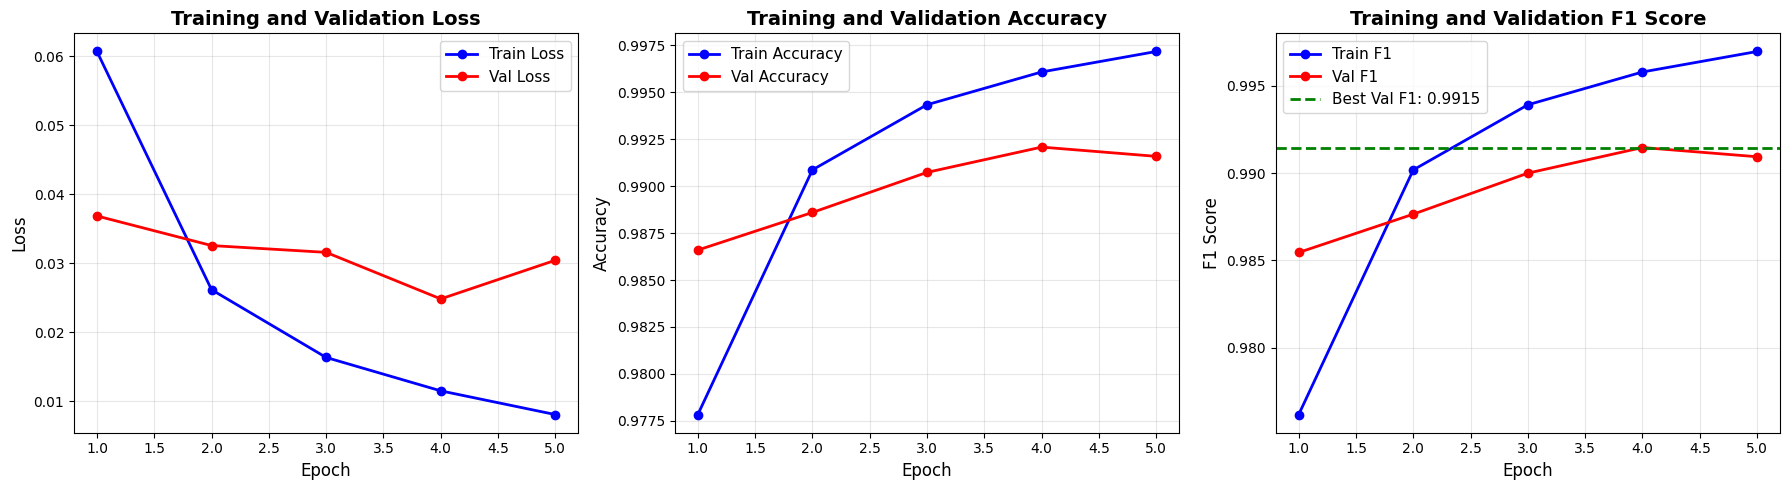

Training history plot saved!


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(epochs_range, history['train_f1'], 'b-o', label='Train F1', linewidth=2)
axes[2].plot(epochs_range, history['val_f1'], 'r-o', label='Val F1', linewidth=2)
axes[2].axhline(y=best_val_f1, color='g', linestyle='--', label=f'Best Val F1: {best_val_f1:.4f}', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved!")

## 12. Load Best Model for Testing

In [12]:
print("Loading best model for final evaluation...")

# Load best checkpoint
best_checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pt')
checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"✓ Loaded best model from Epoch {checkpoint['epoch'] + 1}")
print(f"  Best Validation F1: {checkpoint['val_f1']:.4f}")

Loading best model for final evaluation...
✓ Loaded best model from Epoch 4
  Best Validation F1: 0.9915


## 13. Final Evaluation on Test Set

In [15]:
print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80 + "\n")

test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_probs = validate(
    model, test_loader, criterion, Config.DEVICE
)

print(f"\n{'='*80}")
print("TEST SET RESULTS")
print(f"{'='*80}")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Precision: {test_prec:.4f} ({test_prec*100:.2f}%)")
print(f"  Recall:    {test_rec:.4f} ({test_rec*100:.2f}%)")
print(f"  F1 Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"{'='*80}")


FINAL EVALUATION ON TEST SET



Validating:   0%|          | 0/2537 [00:00<?, ?it/s]


TEST SET RESULTS
  Loss:      0.0270
  Accuracy:  0.9917 (99.17%)
  Precision: 0.9923 (99.23%)
  Recall:    0.9897 (98.97%)
  F1 Score:  0.9910 (99.10%)


## 14. Detailed Classification Report

In [16]:
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(
    test_labels,
    test_preds,
    target_names=['Legitimate (0)', 'Phishing (1)'],
    digits=4
))


Detailed Classification Report:
                precision    recall  f1-score   support

Legitimate (0)     0.9911    0.9934    0.9922     16294
  Phishing (1)     0.9923    0.9897    0.9910     14147

      accuracy                         0.9917     30441
     macro avg     0.9917    0.9915    0.9916     30441
  weighted avg     0.9917    0.9917    0.9917     30441



## 15. Confusion Matrix

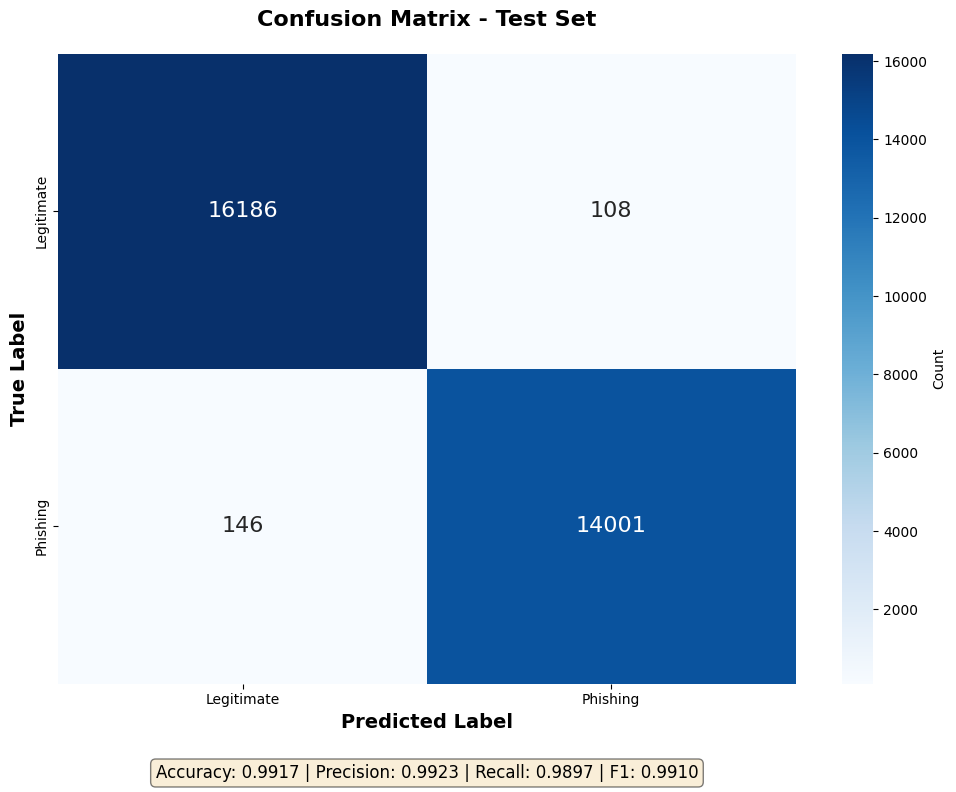


Confusion Matrix Breakdown:
  True Negatives (TN):  16,186 (Correctly identified legitimate emails)
  False Positives (FP): 108 (Legitimate emails flagged as phishing)
  False Negatives (FN): 146 (Phishing emails missed)
  True Positives (TP):  14,001 (Correctly identified phishing emails)


In [25]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Legitimate', 'Phishing'],
    yticklabels=['Legitimate', 'Phishing'],
    cbar_kws={'label': 'Count'},
    annot_kws={'size': 16}
)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)

# Add accuracy text
plt.text(
    0.5, -0.15,
    f'Accuracy: {test_acc:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1: {test_f1:.4f}',
    ha='center',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn:,} (Correctly identified legitimate emails)")
print(f"  False Positives (FP): {fp:,} (Legitimate emails flagged as phishing)")
print(f"  False Negatives (FN): {fn:,} (Phishing emails missed)")
print(f"  True Positives (TP):  {tp:,} (Correctly identified phishing emails)")

## 16. ROC Curve and AUC

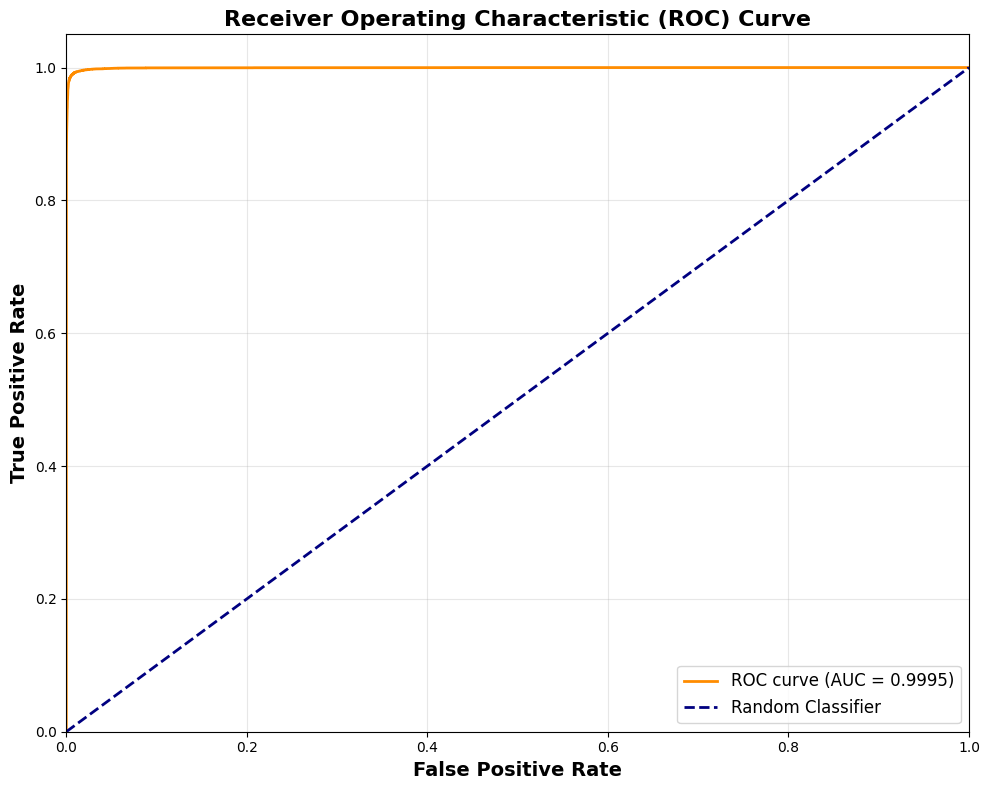


ROC AUC Score: 0.9995


In [18]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")

## 17. Sample Predictions

In [ ]:
# Load test data for samples
test_df = pd.read_csv(Config.TEST_PATH)

# Get some sample predictions
np.random.seed(42)
sample_indices = np.random.choice(len(test_preds), size=10, replace=False)

print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80 + "\n")

for i, idx in enumerate(sample_indices):
    text = test_df.iloc[idx]['text']
    true_label = test_labels[idx]
    pred_label = test_preds[idx]
    prob = test_probs[idx]

    # Truncate text for display
    text_preview = text[:150] + "..." if len(text) > 150 else text

    status = "✓ CORRECT" if true_label == pred_label else "✗ WRONG"

    print(f"Sample {i+1}: {status}")
    print(f"  Text: {text_preview}")
    print(f"  True Label: {'Phishing' if true_label == 1 else 'Legitimate'}")
    print(f"  Predicted: {'Phishing' if pred_label == 1 else 'Legitimate'} (confidence: {prob:.4f})")
    print("─" * 80 + "\n")


SAMPLE PREDICTIONS

Sample 1: ✓ CORRECT
  Text: was comb what carrie Take a look at this ONE!!! Sym8oL: ASVPCurr Price: $0.64 1 Day Target price: $1Action: Aggresive Buy/Hold... 500% profit guarante...
  True Label: Phishing
  Predicted: Phishing (confidence: 1.0000)
────────────────────────────────────────────────────────────────────────────────

Sample 2: ✓ CORRECT
  Text: Date a new friend tonight dobbin Sick and tired of being single? Are you annoyed by your girlfriend or wife Find a new date today. Millions of profile...
  True Label: Phishing
  Predicted: Phishing (confidence: 1.0000)
────────────────────────────────────────────────────────────────────────────────

Sample 3: ✓ CORRECT
  Text: Approval process Arjun. quotDead Ethnic Era Culture Aparna. Rebel British five thirtyone survive symbolize When midnight designate CHILDquot quotthe H...
  True Label: Phishing
  Predicted: Phishing (confidence: 1.0000)
───────────────────────────────────────────────────────────────────────

## 18. Save Final Results to File

In [19]:
# Save results to text file
results_file = os.path.join(Config.RESULTS_DIR, 'final_results.txt')

with open(results_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PHISHING EMAIL DETECTION - FINAL RESULTS\n")
    f.write("="*80 + "\n\n")

    f.write("Model Configuration:\n")
    f.write(f"  BERT Model: {Config.BERT_MODEL}\n")
    f.write(f"  Max Sequence Length: {Config.MAX_LENGTH} tokens\n")
    f.write(f"  LSTM Hidden Size: {Config.LSTM_HIDDEN_SIZE}\n")
    f.write(f"  LSTM Layers: {Config.LSTM_LAYERS}\n")
    f.write(f"  Dropout: {Config.DROPOUT}\n")
    f.write(f"  Frozen Layers: {Config.FREEZE_LAYERS}\n")
    f.write(f"  Trained Layers: {Config.TRAIN_LAYERS}\n")
    f.write(f"  Batch Size: {Config.BATCH_SIZE}\n")
    f.write(f"  Gradient Accumulation: {Config.GRADIENT_ACCUMULATION_STEPS}\n")
    f.write(f"  Effective Batch Size: {Config.EFFECTIVE_BATCH_SIZE}\n")
    f.write(f"  BERT Learning Rate: {Config.BERT_LR}\n")
    f.write(f"  LSTM Learning Rate: {Config.LSTM_LR}\n")
    f.write(f"  Mixed Precision: {Config.USE_AMP}\n")
    f.write(f"  Total Parameters: {total_params:,}\n")
    f.write(f"  Trainable Parameters: {trainable_params:,}\n")
    f.write("\n" + "="*80 + "\n\n")

    f.write("Training Summary:\n")
    f.write(f"  Total Epochs: {len(history['train_loss'])}\n")
    f.write(f"  Best Epoch: {best_epoch}\n")
    f.write(f"  Best Validation F1: {best_val_f1:.4f}\n")
    f.write("\n" + "="*80 + "\n\n")

    f.write("Test Set Performance:\n")
    f.write(f"  Loss:      {test_loss:.4f}\n")
    f.write(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)\n")
    f.write(f"  Precision: {test_prec:.4f} ({test_prec*100:.2f}%)\n")
    f.write(f"  Recall:    {test_rec:.4f} ({test_rec*100:.2f}%)\n")
    f.write(f"  F1 Score:  {test_f1:.4f} ({test_f1*100:.2f}%)\n")
    f.write(f"  ROC AUC:   {roc_auc:.4f}\n")
    f.write("\n" + "="*80 + "\n\n")

    f.write("Confusion Matrix:\n")
    f.write(f"  True Negatives:  {tn:,}\n")
    f.write(f"  False Positives: {fp:,}\n")
    f.write(f"  False Negatives: {fn:,}\n")
    f.write(f"  True Positives:  {tp:,}\n")
    f.write("\n" + "="*80 + "\n")

print(f"\n✓ Results saved to: {results_file}")
print(f"✓ Plots saved to: {Config.RESULTS_DIR}")
print(f"✓ Best model saved to: {best_checkpoint_path}")


✓ Results saved to: /content/drive/MyDrive/email-sms-detection/results/final_results.txt
✓ Plots saved to: /content/drive/MyDrive/email-sms-detection/results
✓ Best model saved to: /content/drive/MyDrive/models/email-sms-detection/best_model.pt


## 19. Summary 

In [ ]:
print("\n" + "="*80)
print("TRAINING PIPELINE COMPLETE!")
print("="*80)

print("\nPerformance Summary:")
print(f"  Test Accuracy:  {test_acc*100:.2f}%")
print(f"  Test F1 Score:  {test_f1*100:.2f}%")
print(f"  Test Precision: {test_prec*100:.2f}%")
print(f"  Test Recall:    {test_rec*100:.2f}%")
print(f"  ROC AUC:        {roc_auc:.4f}")

print("\nSaved Artifacts:")
print(f"  Best model checkpoint")
print(f"  Training history plot")
print(f"  Confusion matrix")
print(f"  ROC curve")
print(f"  Results summary")

print("\n" + "="*80)

In [ ]:
# Find false negatives in test set
test_df = pd.read_csv(Config.TEST_PATH)

# Convert to numpy arrays
test_labels_arr = np.array(test_labels)
test_preds_arr = np.array(test_preds)
test_probs_arr = np.array(test_probs)

# Find where true=1 and pred=0
fn_mask = (test_labels_arr == 1) & (test_preds_arr == 0)
fn_count = fn_mask.sum()

print(f"False negatives found: {fn_count}")

# Get the indices
fn_indices = np.where(fn_mask)[0]

# Show 5 examples
print("\n" + "="*80)
print("MISSED PHISHING EMAILS (False Negatives)")
print("="*80 + "\n")

for i in range(min(5, len(fn_indices))):
    idx = fn_indices[i]
    text = test_df.iloc[idx]['text']
    prob = test_probs_arr[idx]

    print(f"{i+1}. Confidence: {prob:.4f} (below threshold 0.5)")
    print(f"   Length: {len(text)} chars")
    print(f"   Text: {text[:250]}...")
    print("-"*80 + "\n")

False negatives found: 146

MISSED PHISHING EMAILS (False Negatives)

1. Confidence: 0.0574 (below threshold 0.5)
   Length: 921 chars
   Text: hypocritical off He said they started this thread and got people to buy radios and stuff. The actual false story was number three. He said he thinks they could do better than stripping. Howard said that ''Heaven Spelled Backwards'' was a lot of fun, ...
--------------------------------------------------------------------------------

2. Confidence: 0.0009 (below threshold 0.5)
   Length: 798 chars
   Text: :EMCMD: MGN# 401446 Command: MATCH Date: 11/20/2001 Time: 4:46:15 PM TransactionID: 401446 AgencyID: 1673 Recipient: Texas Right To Life Committee Educational Fund 6776 Southwest Frwy Ste 430 Houston, TX 77074-2111 DonorID: 18730 GiftDate: 10/24/2001...
--------------------------------------------------------------------------------

3. Confidence: 0.4358 (below threshold 0.5)
   Length: 684 chars
   Text: A Behind The Scenes Look at Campaign